In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_reader import read_consumption_and_weather

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

from models.base_model import BaseModel

import copy

from utils import *

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [2]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

consumption = df1['consumption'].shift(periods=1, fill_value=0)
target = df1['consumption']
temp = df1['temperature'].shift(periods=1, fill_value=0)
temp_forecast = df1['temperature']

hour = pd.Series(df1.index.hour, name="hour_next_t")
day = pd.Series(df1.index.day, name="day_next_t")
month = pd.Series(df1.index.month, name="month_next_t")
year = pd.Series(df1.index.year, name="year_next_t")

# Concatenate temperature and forecast so that each row contains temp, next day forecast
df_ = pd.concat([temp_forecast, consumption, target], axis=1)
df_ = df_.assign(hour_next_t=hour.values)
df_ = df_.assign(day_next_t=day.values)
df_ = df_.assign(month_next_t=month.values)
df_ = df_.assign(year_next_t=year.values)
df_.columns = ['forecast', 'consumption', 'next_timestep_consumption', 'hour_next_t', 'day_next_t', 'month_next_t', 'year_next_t']
df_ = df_.tail(-1)
df_

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


,forecast,consumption,next_timestep_consumption,hour_next_t,day_next_t,month_next_t,year_next_t
2017-05-01 01:00:00+00:00,3.200000,3325.431995,3344.690998,1,1,5,2017
2017-05-01 02:00:00+00:00,4.000000,3344.690998,3398.359002,2,1,5,2017
2017-05-01 03:00:00+00:00,3.600000,3398.359002,3430.220001,3,1,5,2017
2017-05-01 04:00:00+00:00,3.400000,3430.220001,3606.750000,4,1,5,2017
2017-05-01 05:00:00+00:00,3.100000,3606.750000,3739.876998,5,1,5,2017
...,...,...,...,...,...,...,...
2023-01-21 19:00:00+00:00,-10.233333,5996.773735,5947.502808,19,21,1,2023
2023-01-21 20:00:00+00:00,-11.266667,5947.502808,5868.196111,20,21,1,2023
2023-01-21 21:00:00+00:00,-12.016667,5868.196111,5742.156776,21,21,1,2023
2023-01-21 22:00:00+00:00,-12.083333,5742.156776,5653.673398,22,21,1,2023


In [3]:
# Get the 0.8 first timesteps for training and 0.2 last one for testing
df_train, df_test = train_test_split(df_, test_size=0.2, shuffle=False)
# Divide into train, validation
df_train, df_validation = train_test_split(df_train, test_size=0.1)

# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

# Normalize test set
df_test = (df_test - train_mean) / train_std

# Make Pytorch compatible dataloader
target_test = torch.tensor(df_test['next_timestep_consumption'].values.astype(np.float32))
features_test = torch.tensor(df_test.drop('next_timestep_consumption', axis=1).values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(features_test, target_test)
test_loader = torch.utils.data.DataLoader(dataset=test_tensor, batch_size=25, shuffle=False)

In [4]:
model = BaseModel()
model.to(device)

model.load_state_dict(torch.load('trained_models/ff.pth'))

<All keys matched successfully>

In [5]:
model.eval()

with torch.no_grad():

    predictions = []
    # Test
    for i, data in enumerate(test_loader):
        preds = []
        features, targets = data
        i = 0
        consumption = 0
        for f, t in zip(features, targets):
            if i > 0:
                # Set previous consumption to be the last predicted consumption
                f[1] = consumption
                consumption = model(f)
                preds.append(consumption.item())
            elif i == 0:
                consumption = model(f)
                preds.append(consumption.item())
            i+=1
        
        predictions.append([preds, targets])

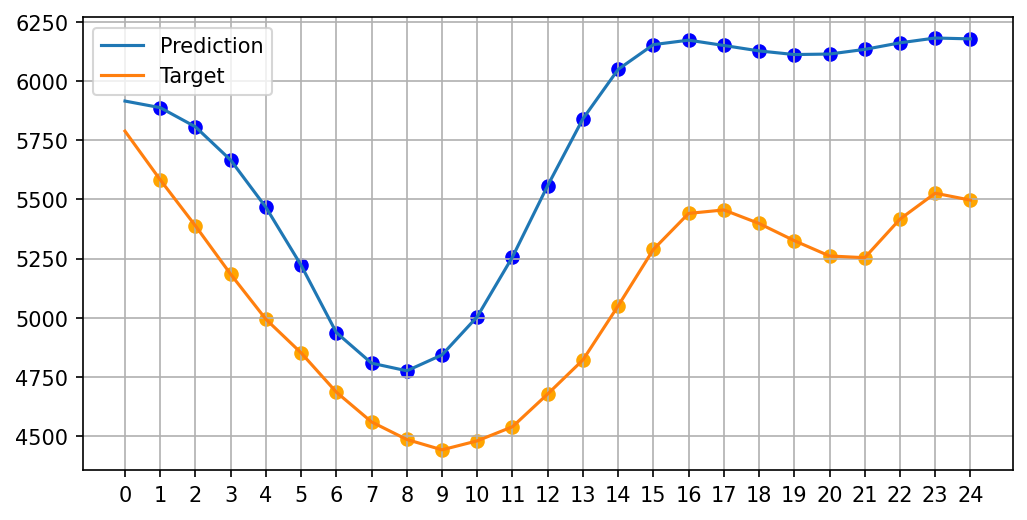

In [9]:
# Plot predictions with true values
prediction_target_plot(predictions, train_mean, train_std, 51)

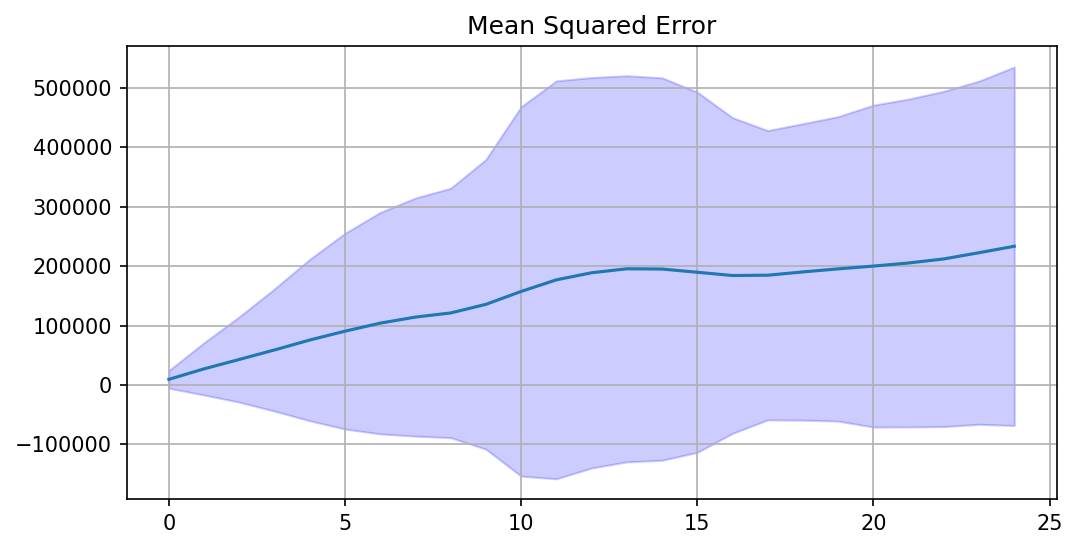

In [7]:
# Plot MSE with standard deviation
mse_plot(predictions, train_mean, train_std)